In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
from packages.load import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose



## Load and clean data:
Since we have covid period and it can mess with our data, we'll do:
split out-of-sampple forcasting into 3 periods: precovid, in covid and after covid.

In [60]:
headline = load_excel('data/hicp_all.xlsx', 'hicp_all')
data_viz(headline, title= 'All-items HICP, 2015 = 100')

Data length: 331 rows from 1996-01-01 00:00:00 to 2023-07-01 00:00:00
0           hicp_all
date                
1996-01-01      75.1
1996-02-01      75.6
1996-03-01      75.7
1996-04-01      75.6
1996-05-01      75.7


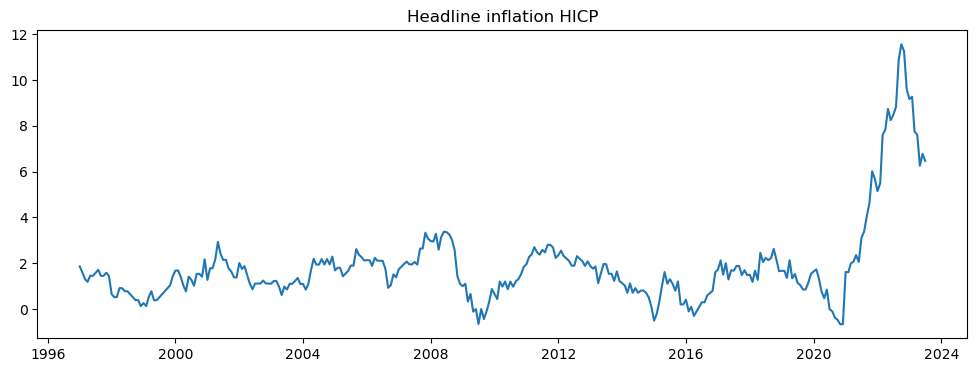

In [62]:
head_inf = transform_yoy_rate(headline)
data_viz(head_inf, title= 'Headline inflation HICP')

### test for autocorr and model:

In [4]:
dftest(head_inf)

Test Statistic        -3.198781
p-value                0.020055
Lags Used             14.000000
Observations Used    304.000000
dtype: float64
Time series is stationary!


/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


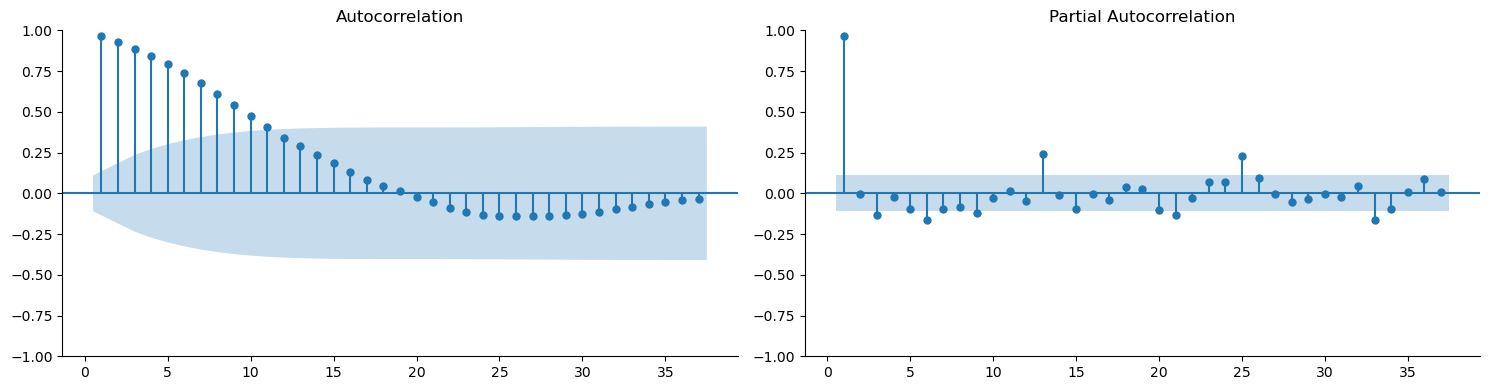

In [5]:
plots(head_inf, lags = 37)

ACF is initially large, then decays gradually to zero, then switch to be negative.
p = 1, 13, 25, 37,... have large PACF -> annual seasonality.

Also I'll split the data so to have out-of-sample forecast, and there's covid time, so I will split like:
training data: 1/1998-12/2015
test 1: 1/2016 - 12/2019 - precovid
test 2: 2020-2021 - during covid
test 3: 2022 - after covid and ukrain war and energy spike

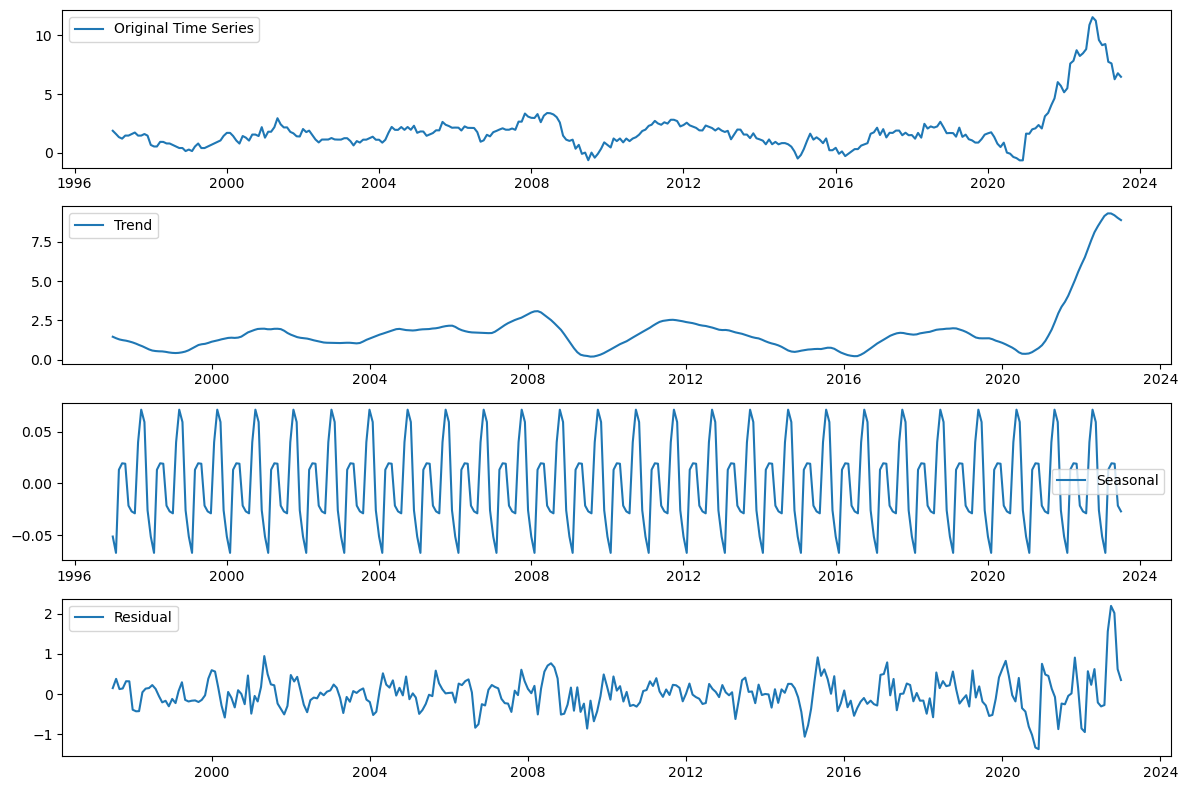

In [6]:
# Apply seasonal decomposition
result = seasonal_decompose(head_inf, model='additive')


# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(head_inf, label='Original Time Series')
plt.legend()

# Plot the trend component
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
head_inf_train = head_inf[head_inf.index <= '2015-12-31']
head_inf_test = head_inf[head_inf.index > '2015-12-31']

## Model:

Try with the most basic model ARMA(1, 0, 0) then try with more complicated model.????

### Model 1

In [18]:
order = (1, 0, 0)

head_inf_train.index.freq = 'MS'

sar = SARIMAX(head_inf_train, 
                order=order,
                seasonal_order=None,
                trend ='n').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33055D-01    |proj g|=  5.17598D-03

At iterate    5    f=  3.33052D-01    |proj g|=  6.90297D-03

At iterate   10    f=  3.33030D-01    |proj g|=  1.23747D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     34      1     0     0   1.973D-05   3.330D-01
  F =  0.33302997813001400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               yoy_rate   No. Observations:                  228
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -75.931
Date:                Tue, 13 Feb 2024   AIC                            155.862
Time:                        08:55:40   BIC                            162.720
Sample:                    01-01-1997   HQIC                           158.629
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9784      0.013     73.021      0.000       0.952       1.005
sigma2         0.1124      0.010     11.811      0.000       0.094       0.131
===================================================================================
Ljung-Box (L1) (Q):                   4.74   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.03   Prob(JB):                         0.13
Heteroskedasticity (H):               1.22   Skew:                            -0.19
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model 2:

In [17]:
stepwise_model = pm.auto_arima(head_inf_train, 
                            start_p=2, start_q=0,
                           max_p=12, max_q=12, m=12,
                           start_P=1, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                            information_criterion='bic') 
print(stepwise_model.bic())
print(stepwise_model.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,0)(1,1,1)[12] intercept   : BIC=inf, Time=1.85 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=653.292, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=290.267, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=648.316, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=355.334, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=228.659, Time=1.06 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=inf, Time=3.68 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=inf, Time=1.94 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : BIC=595.736, Time=0.51 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : BIC=230.600, Time=2.19 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : BIC=231.492, Time=2.04 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : BIC=451.061, Time=0.65 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : BIC=233.453, Time=3.12 sec
 ARIMA(1,0,0)(2,1,0)[12]             : BIC=223.42

- The estimated standard deviation of the residuals (errors) is 0.1397. -> not 0
- Ljung-Box (Q): A test for autocorrelation of residuals. A value of 2.75 is observed, and a low p-value (0.10) suggests that there might be significant autocorrelation.
- Jarque-Bera (JB): A test for normality of residuals. The JB statistic is 1.27, and the p-value is 0.53, indicating that normality is not significantly violated.
- Heteroskedasticity (H): A test for constant variance of residuals. The H statistic is 1.23, and the p-value is 0.38, suggesting that there is no significant heteroskedasticity.

Skewness and Kurtosis:
- Skewness is approximately -0.02, indicating a slight left skewness.
- Kurtosis is 3.37, suggesting a distribution with moderate peakedness.


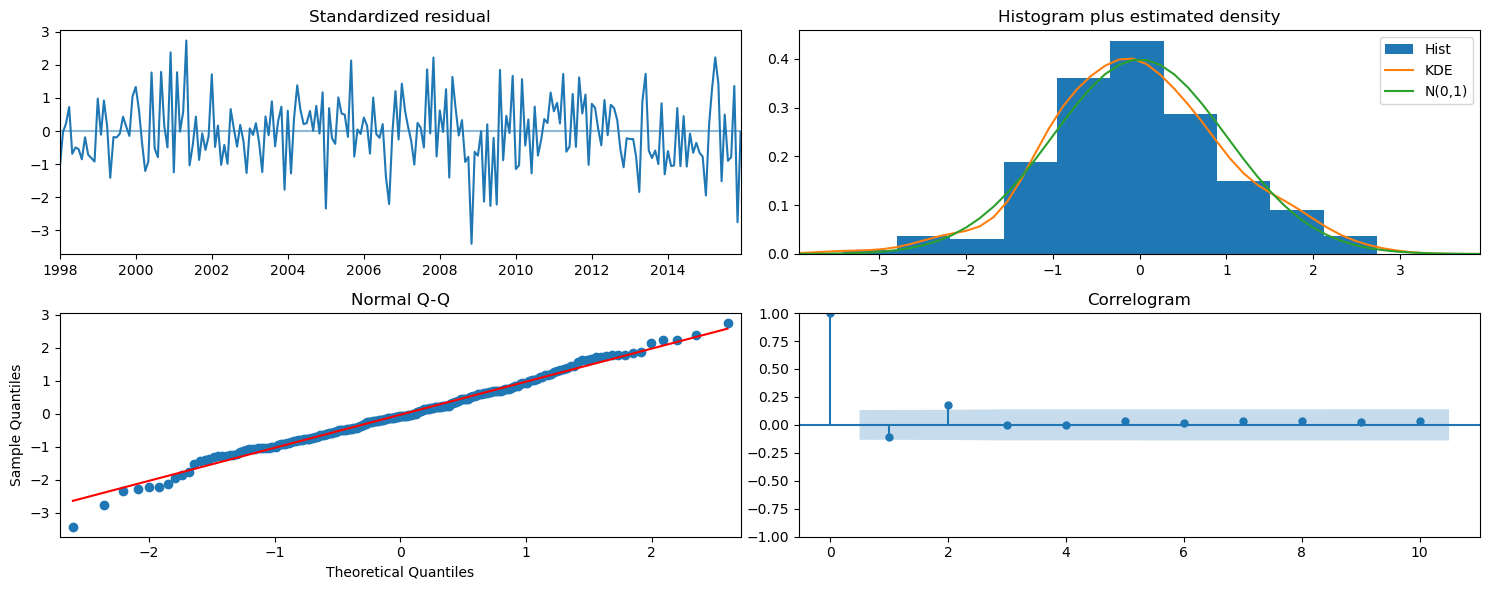

In [9]:
stepwise_model.plot_diagnostics(figsize= (15, 6))
plt.tight_layout()
plt.show()

In [10]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (1, 0, 0)
seasonal order:  (2, 1, 0, 12)


In [20]:
head_inf_train.index.freq = 'MS'

sar = SARIMAX(head_inf_train, 
                order=(1, 0, 0),
                seasonal_order=seasonal_order,
                trend ='n').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00171D-01    |proj g|=  6.03343D-01


 This problem is unconstrained.



At iterate    5    f=  4.53861D-01    |proj g|=  4.05000D-02

At iterate   10    f=  4.42960D-01    |proj g|=  8.57747D-03

At iterate   15    f=  4.42817D-01    |proj g|=  5.14621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   6.935D-06   4.428D-01
  F =  0.44281718911592877     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           yoy_rate   No. Observations:                  228
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -100.962
Date:                            Tue, 13 Feb 2024   AIC                            209.925
Time:                                    08:57:27   BIC                            223.426
Sample:                                01-01-1997   HQIC                           215.379
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9309      0.024     38.708      0.000       0.884       0.978
ar.S.L12      -0.8657      0.056    -15.328      0.000      -0.976      -0.755
ar.S.L24      -0.5391      0.065     -8.355      0.000      -0.666      -0.413
sigma2         0.1397      0.013     10.890      0.000       0.115       0.165
===================================================================================
Ljung-Box (L1) (Q):                   2.75   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.10   Prob(JB):                         0.53
Heteroskedasticity (H):               1.23   Skew:                            -0.02
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


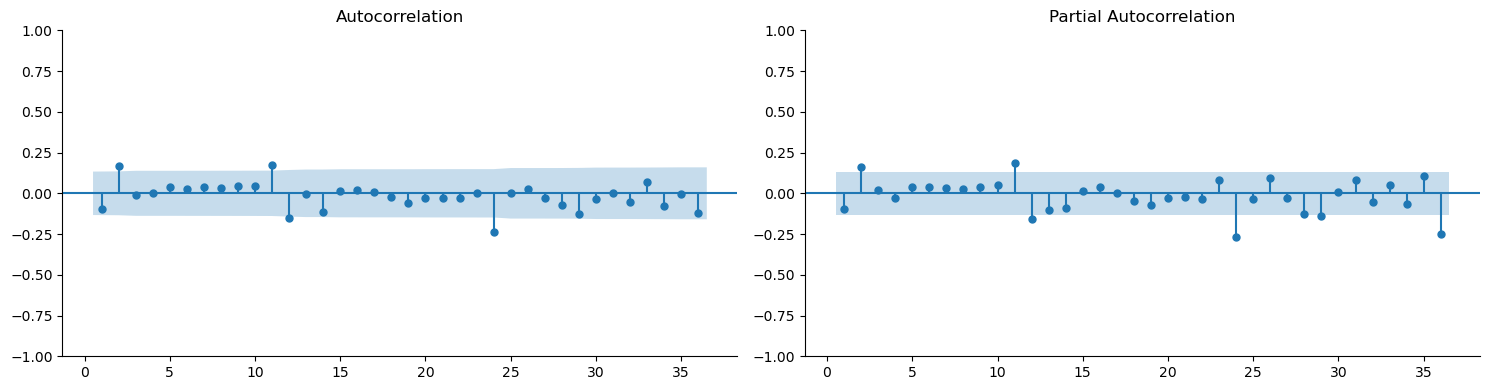

In [21]:
#plot the residuals

plots(sar.resid[sar.loglikelihood_burn:], lags=36);

Residuals are not white noise and still autocorrelated.

Now let's do out-of-sample forecast and calculate RMSE. 

## Forecast:
### Recursive Approach:
We apply the optimised model but adding more data recursively.

In [64]:
T = len(head_inf_train)
N = len(head_inf) - T
horizons = [1, 2, 3] # horizon

# Create empty lists to store the forecasts
forecast_df = pd.DataFrame()

# Iterate through the time series data
for h in horizons:
    forecasts = []    
    for i in range(1, N+1):
    
        # Define the expanding window training set
        train_data = head_inf[:T+i-h]
        print(f'Horizon {h}, step {i}')

        # Create and fit the SARIMAX model
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, trend='n')
        model_fit = model.fit(disp = False)
    
        # Forecast h step ahead
        pred = model_fit.forecast(steps =h)
        print('Prediction: ', pred)
        forecasts.append(pred[-1])
    # Assign the forecasted values to a new column in the DataFrame
    forecast_df[f'Horizon_{h}'] = forecasts
    
forecast_df['Real_obs'] = head_inf_test.values
forecast_df.set_index(head_inf_test.index, inplace = True)

Horizon 1, step 1
Prediction:  2016-01-01    0.072791
Freq: MS, dtype: float64
Horizon 1, step 2
Prediction:  2016-02-01    0.41172
Freq: MS, dtype: float64
Horizon 1, step 3
Prediction:  2016-03-01    0.005707
Freq: MS, dtype: float64
Horizon 1, step 4
Prediction:  2016-04-01    0.014424
Freq: MS, dtype: float64
Horizon 1, step 5
Prediction:  2016-05-01   -0.036565
Freq: MS, dtype: float64
Horizon 1, step 6
Prediction:  2016-06-01    0.228816
Freq: MS, dtype: float64
Horizon 1, step 7
Prediction:  2016-07-01    0.144667
Freq: MS, dtype: float64
Horizon 1, step 8
Prediction:  2016-08-01    0.153543
Freq: MS, dtype: float64
Horizon 1, step 9
Prediction:  2016-09-01    0.325119
Freq: MS, dtype: float64
Horizon 1, step 10
Prediction:  2016-10-01    0.485528
Freq: MS, dtype: float64
Horizon 1, step 11
Prediction:  2016-11-01    0.758167
Freq: MS, dtype: float64
Horizon 1, step 12
Prediction:  2016-12-01    0.458614
Freq: MS, dtype: float64
Horizon 1, step 13
Prediction:  2017-01-01    1.32

In [65]:
for h in horizons:
    forecast_df[f'Error_horizon_{h}'] = forecast_df['Real_obs'] - forecast_df[f'Horizon_{h}']
forecast_df.head()

,Horizon_1,Horizon_2,Horizon_3,Real_obs,Error_horizon_1,Error_horizon_2,Error_horizon_3
date,,,,,,,
2016-01-01,0.072791,0.082843,0.989463,0.407747,0.334957,0.324905,-0.581716
2016-02-01,0.411720,0.099485,0.109006,-0.101010,-0.512730,-0.200495,-0.210016
2016-03-01,0.005707,0.487820,0.197738,0.100301,0.094594,-0.387519,-0.097437
2016-04-01,0.014424,-0.074606,0.379617,-0.299401,-0.313825,-0.224795,-0.679018
2016-05-01,-0.036565,0.258348,0.173327,-0.099404,-0.062838,-0.357752,-0.272730


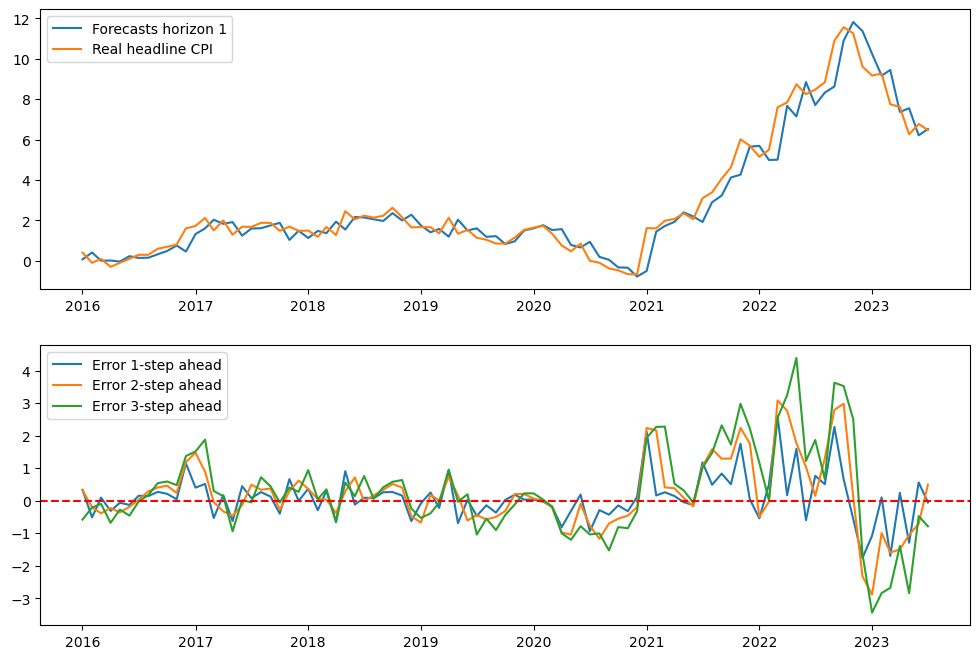

In [66]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(forecast_df.index, forecast_df['Horizon_1'], label = 'Forecasts horizon 1')
plt.plot(forecast_df['Real_obs'], label = 'Real headline CPI')
plt.legend()

plt.subplot(212)
plt.plot(forecast_df['Error_horizon_1'], label = 'Error 1-step ahead')
plt.plot(forecast_df['Error_horizon_2'], label = 'Error 2-step ahead')
plt.plot(forecast_df['Error_horizon_3'], label = 'Error 3-step ahead')

plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.legend()
plt.show()


We can see the horizon 1 is the delayed results of CPI

test 1: 1/2016 - 12/2019 - precovid
test 2: 2020-2021 - during covid
test 3: 2022 - after covid and war and energy spike

In [67]:
# Cut into test set and calculate the avg of error during different periods:

pre_covid = '2019-12-31'
end_covid = '2021-12-31'

# Define custom date ranges
custom_date_ranges = [
    ('01-01-2016 to 31-12-2019', forecast_df.index < pre_covid),
    ('01-01-2020 to 31-12-2021', (forecast_df.index >= pre_covid) & (forecast_df.index < end_covid)),
    ('01-01-2022 to 2023', forecast_df.index >= end_covid)
]

# Add a new column for custom date ranges
forecast_df['Date Range'] = pd.Categorical([label for label, condition in custom_date_ranges for _ in condition if _])
pivot_table = forecast_df.pivot_table(index='Date Range', values=['Error_horizon_1',
       'Error_horizon_2', 'Error_horizon_3'], aggfunc='mean')
pivot_table


,Error_horizon_1,Error_horizon_2,Error_horizon_3
Date Range,,,
01-01-2016 to 31-12-2019,0.056658,0.108098,0.133616
01-01-2020 to 31-12-2021,0.174661,0.342582,0.438886
01-01-2022 to 2023,0.125483,0.258285,0.456444
